# Spatial transcriptome

We demonstrate a noise reduction with RECODE for spatial transcriptome data. We use spatial transcriptome data of mouse embryos at E16.5, which is generated by Stereo-seq. The dataset is available from [MOSTA](https://db.cngb.org/stomics/mosta/download/). 

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write data. Import numpy and scanpy in addlition to screcode.

In [23]:
import scanpy as sc
import numpy as np
import screcode
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import pandas as pd

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [9]:
INPUT_DIR = 'data/Xenium_V1_Human_Ductal_Adenocarcinoma_FFPE_outs'
INPUT_FILE = "cell_feature_matrix.h5"
Raw_key = "count"
adata = sc.read_10x_h5("%s/%s" % (INPUT_DIR,INPUT_FILE))
adata.obs = pd.read_csv("%s/cells.csv.gz" % INPUT_DIR)
adata.var_names_make_unique()
adata = adata[:,np.sum(adata.X,axis=0)>0]
adata = adata[np.sum(adata.X,axis=1)>0]
adata.layers["Raw"] = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 234857 × 380
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'Raw'

## Apply RECODE
Apply RECODE to the count matrix (without using spatial coordinates).

In [11]:
import screcode
recode = screcode.RECODE(seq_target='RNA',version=2)
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 380, '#non-significant genes': 0, '#silent genes': 0, 'ell': 128, 'Elapsed time': '0h 1m 15s 913ms', 'solver': 'randomized', '#test_data': 46971}


### Performance check

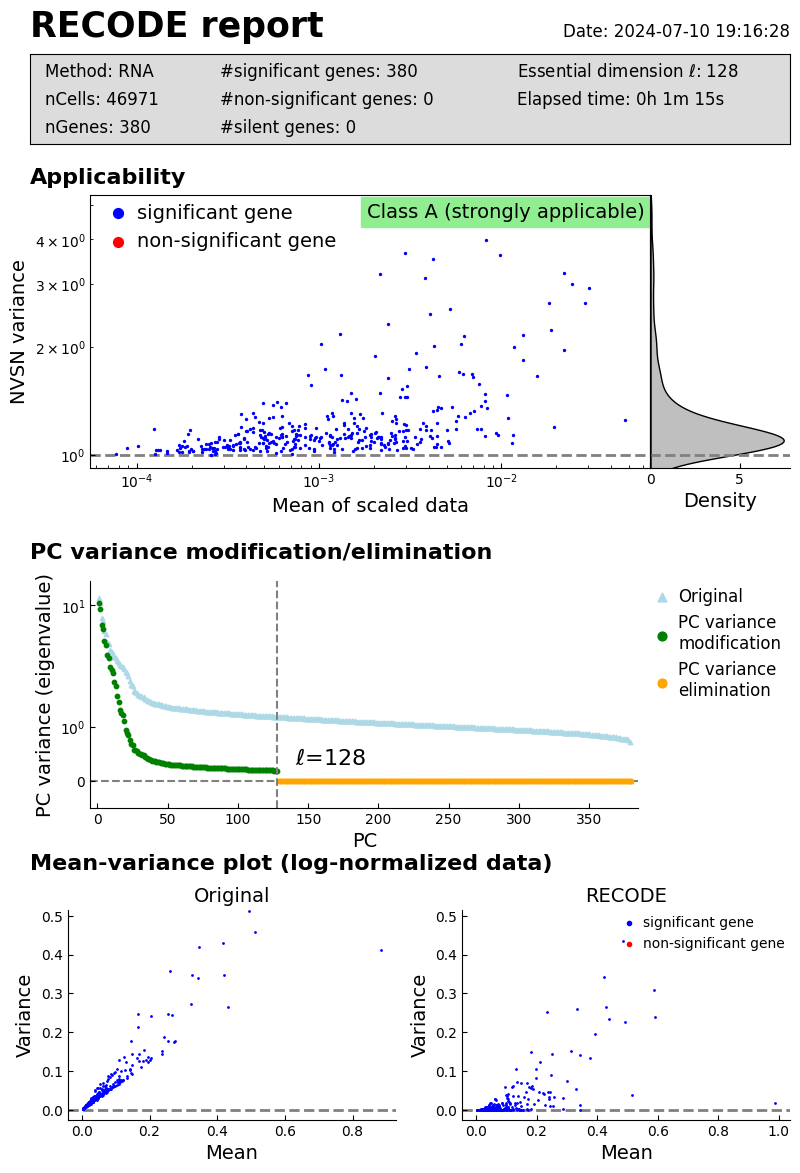

In [12]:
recode.report()

Log normalizaation

In [13]:
target_sum = np.median(np.sum(adata.layers["RECODE"],axis=1))
adata = recode.lognormalize(adata,target_sum=target_sum)
print(np.median(np.sum(adata.layers["RECODE"],axis=1)))

Normalized data are stored in "RECODE_norm" and "RECODE_log"
46.68497


In [20]:
adata.layers["Raw_norm"] = target_sum*adata.layers["Raw"]/np.sum(adata.layers["Raw"],axis=1)[:,np.newaxis]
adata.layers["Raw_log"] = np.log(adata.layers["Raw_norm"]+1)

Plot spatial gene expression

In [35]:
def spatial_gex(
        genes,
        sp_x = adata.obs["x_centroid"], 
        sp_y = -adata.obs["y_centroid"],
        psize = 1,
        figsize=(8,4),
        dpi=100,
        percentiles = [10,90],
        fs_title = 20,
        fs_label = 20,
    ):
    fig,ax = plt.subplots(2,len(genes),figsize=(figsize[0]*len(genes),figsize[1]*2),tight_layout=True)
    for i in range(len(genes)):
        idx_gene = adata.var.index == genes[i]
        exp = adata.layers["RECODE_log"][:,idx_gene]
        vmin,vmax = np.percentile(exp,percentiles[0]),np.percentile(exp,percentiles[1])
        ax_ = ax[1,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax)
        if i== 0:
            ax_.set_ylabel("RECODE",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]
        else:
            ax_.axis('off')

        
        exp = adata.layers["Raw_log"][:,idx_gene]
        ax_ = ax[0,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax)
        ax_.set_title("$\it{%s}$" % genes[i],fontsize=fs_title)
        if i== 0:
            ax_.set_ylabel("Raw",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]
        else:
            ax_.axis('off')

spatial_gex(genes = ["CD3D","CD4","CXCL1","CXCL5"])
spatial_gex(genes = ["EPCAM","IFNGR1","IL1R1","ACTB"])

IndexError: index -1 is out of bounds for axis 0 with size 0